In [23]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [24]:
import csv
from scipy.optimize import *
from numpy.lib.recfunctions import *
from utils import *
from data import *

In [25]:
# Print data columns
x.dtype.names

('classification',
 'distance_to_port',
 'distance_to_shore',
 'measure_course_diff',
 'measure_courseavg_10800',
 'measure_courseavg_1800',
 'measure_courseavg_21600',
 'measure_courseavg_3600',
 'measure_courseavg_43200',
 'measure_courseavg_86400',
 'measure_coursestddev_10800',
 'measure_coursestddev_1800',
 'measure_coursestddev_21600',
 'measure_coursestddev_3600',
 'measure_coursestddev_43200',
 'measure_coursestddev_86400',
 'measure_distance_to_port',
 'measure_heading_diff',
 'measure_new_score_10800',
 'measure_new_score_1800',
 'measure_new_score_21600',
 'measure_new_score_3600',
 'measure_new_score_43200',
 'measure_new_score_86400',
 'measure_pos_10800',
 'measure_pos_1800',
 'measure_pos_21600',
 'measure_pos_3600',
 'measure_pos_43200',
 'measure_pos_86400',
 'measure_speed',
 'measure_speed_diff',
 'measure_speedavg_10800',
 'measure_speedavg_1800',
 'measure_speedavg_21600',
 'measure_speedavg_3600',
 'measure_speedavg_43200',
 'measure_speedavg_86400',
 'measure_spe

In [26]:
windows = [int(name[len("measure_courseavg_"):]) for name in x.dtype.names if name.startswith("measure_courseavg_")]
windows.sort()
print windows

[1800, 3600, 10800, 21600, 43200, 86400]


In [27]:
for window in windows:
    x = append_fields(x, 'measure_speedstddev_%s_log' % window, [], dtypes='<f8', fill_value=0.0)
    x['measure_speedstddev_%s_log' % window] = log10(x['measure_speedstddev_%s' % window]+0.001)

    x = append_fields(x, 'measure_coursestddev_%s_log' % window, [], dtypes='<f8', fill_value=0.0)
    x['measure_coursestddev_%s_log' % window] = log10(x['measure_coursestddev_%s' % window]+0.001)


In [28]:
windows = [43200]

In [29]:
grade = 4
colnames = []
#colnames.append("speed")
for window in windows:
    colnames.append('measure_speedavg_%s' % window)
    colnames.append('measure_speedstddev_%s_log' % window)
    colnames.append('measure_coursestddev_%s_log' % window)
    
cols = [x[col] for col in colnames]
    
score_args = curve_fit(mpolynomial, cols, x['classification'], [1]*(len(cols)*grade))[0]

print score_args

[ -4.93476416e+02  -6.89408463e+00   1.49592824e+01  -9.39170147e+00
   1.50645878e+02  -1.52138106e+00  -1.08817054e+00  -2.09136308e-01
   3.43542952e+02  -1.12446817e+00  -1.19029177e+00  -2.85164010e-01]


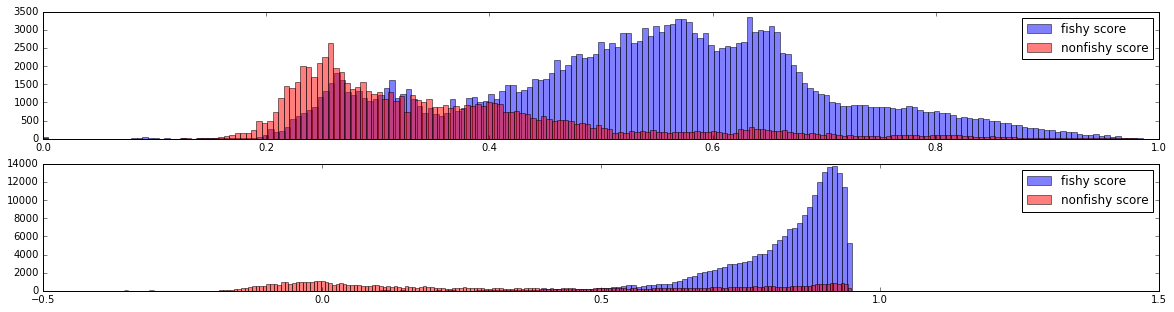

Error for measure_new_score: 42.1728959889%
Error for score: 12.2163387502%


In [31]:
try:
    x = append_fields(x, 'score', [], dtypes='<f8', fill_value=0.0)
except:
    pass

x['score'][:] = mpolynomial(cols, *score_args)

xfishy = fishy(x)
xnonfishy = nonfishy(x)


histfig = figure(figsize=(20,5))

subplot = histfig.add_subplot(211)
new_score_fishy = center_hist_bins(subplot.hist(xfishy["measure_new_score_3600"][xfishy['distance_to_shore'] > 3], bins=200, normed=False, color='b', alpha=0.5, label="fishy score"))
new_score_nonfishy = center_hist_bins(subplot.hist(xnonfishy["measure_new_score_3600"][xnonfishy['distance_to_shore'] > 3], bins=200, normed=False, color='r', alpha=0.5, label="nonfishy score"))
legend()

subplot = histfig.add_subplot(212)
score_fishy = center_hist_bins(subplot.hist(xfishy["score"][xfishy['distance_to_shore'] > 3], bins=200, normed=False, color='b', alpha=0.5, label="fishy score"))
score_nonfishy = center_hist_bins(subplot.hist(xnonfishy["score"][xnonfishy['distance_to_shore'] > 3], bins=200, normed=False, color='r', alpha=0.5, label="nonfishy score"))
legend()


show()


total = sum(new_score_fishy[0] + new_score_nonfishy[0])
non_overlap = sum(abs(new_score_fishy[0] - new_score_nonfishy[0]))
overlap = total - non_overlap
error = overlap / total

print "Error for measure_new_score: %s%%" % (error * 100)


total = sum(score_fishy[0] + score_nonfishy[0])
non_overlap = sum(abs(score_fishy[0] - score_nonfishy[0]))
overlap = total - non_overlap
error = overlap / total

print "Error for score: %s%%" % (error * 100)

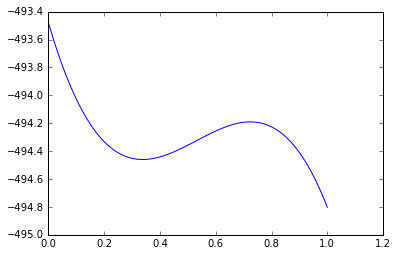

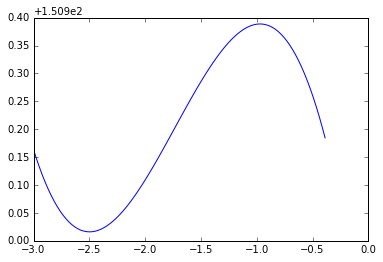

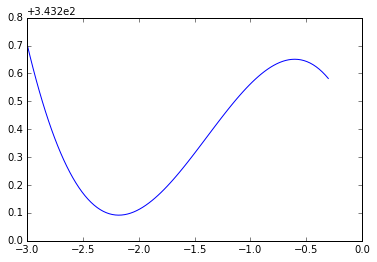

In [22]:
grade = len(score_args) / len(colnames)
pos = 0
for col in colnames:
    xs = linspace(min(x[col]), max(x[col]), 100)
    ys = polynomial(xs, *score_args[pos:pos+grade])
    plot(xs, ys)
    show()
    pos += grade


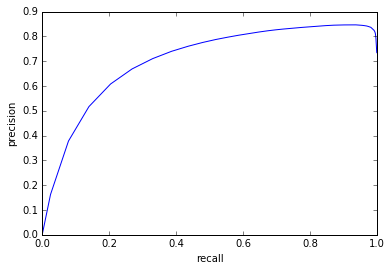

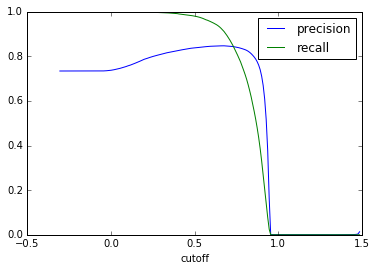

In [59]:
precall = np.zeros((len(score_fishy[0]),), dtype=[('precision', 'f8'), ('recall', 'f8')])

for cutoff in xrange(0, len(score_fishy[0])):
    positives = sum(score_fishy[0][cutoff:] + score_nonfishy[0][cutoff:])
    true_positives = sum(score_fishy[0][cutoff:])
    true = sum(score_fishy[0])

    precall['precision'][cutoff] = true_positives / positives
    precall['recall'][cutoff] = true_positives / true
    
plot(precall['recall'], precall['precision'])
plt.xlabel("recall")
plt.ylabel("precision")
show()

plot(score_fishy[1], precall['precision'], label="precision")
plot(score_fishy[1], precall['recall'], label="recall")
legend()
plt.xlabel("cutoff")
show()